# Regression in Keras: Predicting House Prices

* Regression problems need a different loss function than classification: MSE, MAE are commonly used
* Likewise, we need a different evaluation metric. Accuracy is meaningless; MAE is commonly used
* In this example, we need to normalize our features as they are on different scales
* Especially when there is little data, k-fold cross-validation is a more reliable way to evaluate a model than a single train-test split
* When there is little training data, a small model (ie few hidden layers) is preferable to control overfitting

In [21]:
from keras import models, layers
from keras.datasets import boston_housing
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

## Get and prepare data

In [4]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data();
print(train_data.shape)
print(test_data.shape)
train_targets[:10]

(404, 13)
(102, 13)


array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,  14.4])

### Normalize features

Normalize on mean and standard deviation of the __training data__.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

train_data[:2]

array([[-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
        -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
         1.14850044,  0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, -0.25683275, -1.21518188,
         1.89434613, -1.91036058,  1.24758524, -0.85646254, -0.34843254,
        -1.71818909,  0.43190599, -1.32920239]])

## Build network

In this example, we build a model using a function.

In [8]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## Set up k-fold cv

In [14]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold {}'.format(i))
    
    # Prepare validation data from partition #k
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare training data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples], 
         train_data[(i+1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build and compile Keras model 
    model = build_model()

    # Train model
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


In [16]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

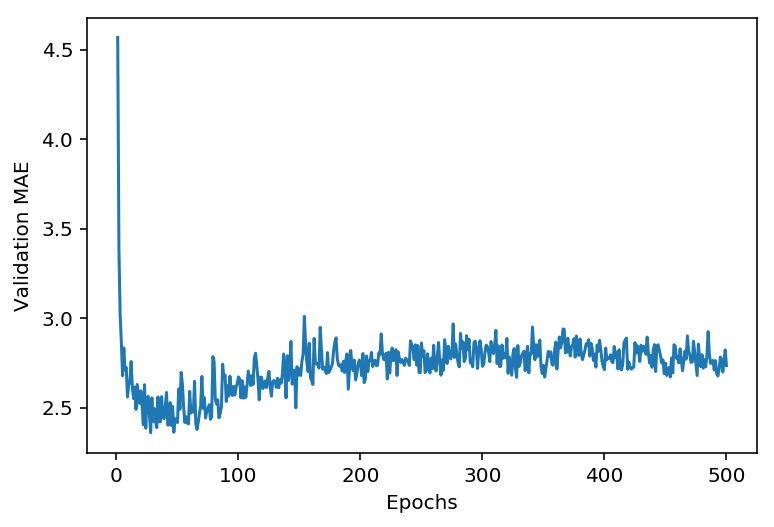

In [23]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Drop the first few data points (due to scale) and smooth

In [19]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

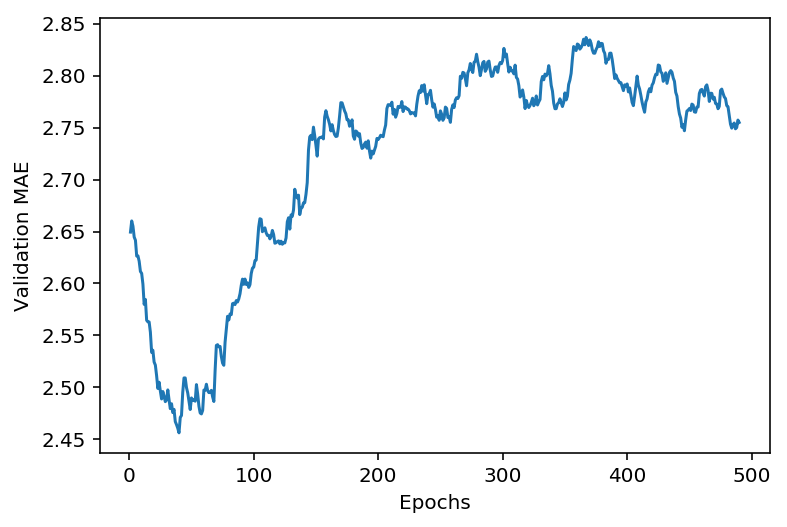

In [22]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Final model

In [24]:
# Get new, compiled model
model = build_model()

# Train on the entire data set
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

 32/102 [========>.....................] - ETA: 0s

2.8984323108897492